<a href="https://colab.research.google.com/github/PGV1000/big_data_analysis_tech/blob/main/3_%D0%9F%D0%A0_%D0%9C%D0%B5%D0%B4%D0%B2%D0%B5%D0%B4%D0%B5%D0%B2_%D0%9F%D0%98_6_%D0%9F%D1%80%D0%B8%D0%BC%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D0%BE%D0%B2_%D0%B3%D0%BB%D1%83%D0%B1%D0%BE%D0%BA%D0%BE%D0%B3%D0%BE_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F_%D0%B2_%D1%81%D1%80%D0%B5%D0%B4%D0%B5_Apache_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **6. Применение методов глубокого обучения в среде Apache Spark**

- Обучение моделей глубокого обучения в среде Apache Spark на Python может быть выполнено с помощью [различных библиотек и инструментов](https://github.com/christianversloot/machine-learning-articles/blob/main/distributed-training-tensorflow-and-keras-models-with-apache-spark.md). Одним из таких инструментов является [**Elephas**](https://github.com/maxpumperla/elephas/tree/master), который предоставляет интерфейс для обучения моделей Keras на Spark. **Elephas** позволяет обучать модели глубокого обучения на больших наборах данных, распределенных по кластеру Spark.

- Важно отметить, что при работе с большими данными и обучении моделей глубокого обучения в среде Apache Spark необходимо учитывать ряд важных аспектов, таких как оптимизация использования памяти, эффективное распределение задач между рабочими узлами и управление ресурсами кластера.




#### Ссылка на русифицированное [Elephas README](https://colab.research.google.com/drive/1WDoyq_NoLYVUKxeGvG-IUs1G7xlwsQRq?usp=sharing)

https://github.com/maxpumperla/elephas/blob/master/elephas.gif

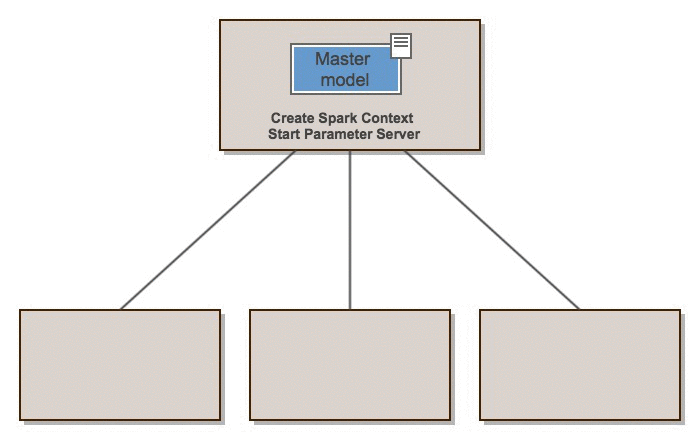

Обучение модели глубокого обучения с использованием elephas можно реализовать следующими способами, в основном используя один из этих классов:

1. **elephas.spark_model.SparkModel**:
   - `SparkModel` предназначен для обучения моделей глубокого обучения на больших наборах данных с использованием Apache Spark.
   - Он использует Resilient Distributed Dataset (RDD), основную абстракцию данных в Spark, для обучения модели. RDD представляет собой неизменяемую распределенную коллекцию объектов.
   - `SparkModel` сериализует модель Keras и отправляет ее на рабочие узлы вместе с данными и транслируемыми параметрами модели.
   - `SparkModel` также может быть использован для распределенного вывода (предсказания) и оценки.

2. **elephas.ml_model.ElephasEstimator**:
   - `ElephasEstimator` представляет собой оценщик Spark ML, который обучает модель Keras на DataFrame.
   - Он использует DataFrame, которые являются распределенными коллекциями данных, организованными в именованные столбцы. DataFrame предоставляют более высокоуровневый, более структурированный интерфейс, чем RDD.
   - `ElephasEstimator` обучает модель Keras на DataFrame, используя Spark ML Pipelines. Это позволяет интегрировать обучение моделей глубокого обучения с другими этапами обработки данных в Spark ML.

В обоих случаях модели обучаются в распределенном режиме, но `ElephasEstimator` предоставляет более тесную интеграцию с экосистемой Spark ML. Выбор между `SparkModel` и `ElephasEstimator` зависит от ваших конкретных требований и структуры ваших данных.

## **1. Обучение модели глубокого обучения, исполльзуя класс elephas.spark_model.SparkModel**

In [ ]:
%%capture
!pip install elephas
!pip install findspark
!pip install numpy==1.26.0

# Перезапуск среды выполнения
import os
os.kill(os.getpid(), 9)

# После установки библиотек появится сообщение "Сеанс прекращен по неизвестной причине."
# Так и должно быть. Запускайте код в следующих далее ячейках.

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.utils import to_categorical

from elephas.spark_model import SparkModel
from elephas.utils.rdd_utils import to_simple_rdd

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import findspark

findspark.init()

In [ ]:
conf = SparkConf().setMaster("local").setAppName("Data Analysis")
sc = SparkContext(conf = conf)
spark = SparkSession(sc)

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

x_train = x_train[:5000]
x_test = x_test[:1000]
y_train = y_train[:5000]
y_test = y_test[:1000]

x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

11490434/11490434 [==============================] - 0s 0us/step
5000 train samples
1000 test samples


In [ ]:
batch_size = 64
nb_classes = 10
epochs = 1

In [ ]:
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

model = Sequential()
model.add(Dense(128, input_dim=784))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))

sgd = SGD(learning_rate=0.1)
model.compile(sgd, 'categorical_crossentropy', ['acc'])

In [ ]:
# Сохраняем модель перед использованием в Spark для избежания ошибок, связанных с сериализацией
model.save('temp_model.h5')

# Загружаем модель снова
from tensorflow.keras.models import load_model
model = load_model('temp_model.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### **Пример обучения модели в асинхронном режиме (mode='asynchronous')**



**Особенности ассинхронного режима:**
- Рабочие узлы (workers) обрабатывают данные **независимо друг от друга** Каждый рабочий узел отправляет обновления градиентов на центральный сервер параметров, не дожидаясь других узлов
- Обновления параметров модели происходят сразу после получения градиентов от любого узла
- **Преимущество**: быстрее работает, так как нет задержек на синхронизацию между узлами
- **Недостаток**: может привести к менее стабильному обучению, поскольку некоторые узлы могут работать с устаревшими параметрами модели



In [ ]:
# Создание обучающего набора RDD из массива numpy
rdd = to_simple_rdd(sc, x_train, y_train)

# Инициализация SparkModel из модели tensorflow.keras и контекста Spark
spark_model = SparkModel(model, frequency='epoch', mode='asynchronous')

# Обучение модели Spark
spark_model.fit(rdd, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.1)

# Оценка модели Spark путем оценки базовой модели
score = spark_model.evaluate(x_test, y_test, verbose=2)

>>> Fit model
 * Serving Flask app 'elephas.parameter.server'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://172.28.0.12:4000
INFO:werkzeug:Press CTRL+C to quit


>>> Initialize workers
>>> Distribute load


INFO:werkzeug:172.28.0.12 - - [27/Mar/2025 15:46:46] "GET /parameters HTTP/1.1" 200 -
INFO:werkzeug:172.28.0.12 - - [27/Mar/2025 15:46:47] "POST /update HTTP/1.1" 200 -
INFO:werkzeug:172.28.0.12 - - [27/Mar/2025 15:46:48] "GET /parameters HTTP/1.1" 200 -


>>> Async training complete.


Параметр `frequency` в `SparkModel` определяет, как часто обновляются веса модели во время обучения.

Если `frequency='epoch'`, то обновление весов происходит после каждой эпохи обучения. Это означает, что каждый рабочий узел обучает модель на своем подмножестве данных за одну эпоху, затем отправляет обновленные веса на драйвер. Драйвер затем агрегирует эти обновления и применяет их к основной модели.

Вариант `frequency='batch'` означает, что обновление весов происходит после каждого пакета данных. Это может привести к более частым обновлениям, но также может увеличить накладные расходы из-за частой коммуникации между рабочими узлами и драйвером.

In [ ]:
print('Точность на тестовых данных:', score[1])

Точность на тестовых данных: 0.6859999895095825


#### **Пример обучения модели в синхронном режиме (mode='synchronous')**


**Особенности синхронного режима:**

- Все рабочие узлы обрабатывают свои части данных, а затем **ожидают завершения** работы всех остальных узлов
- Градиенты от всех рабочих узлов агрегируются (обычно усредняются) и только потом применяются для обновления модели
- Обучение происходит поэтапно, все рабочие узлы остаются синхронизированными
- **Преимущество**: обычно обеспечивает более стабильное обучение и сходимость
- **Недостаток**: может работать медленнее из-за накладных расходов на синхронизацию

In [ ]:
# Создание обучающего набора RDD из массива numpy
rdd = to_simple_rdd(sc, x_train, y_train)

# Инициализация SparkModel из модели tensorflow.keras и контекста Spark
spark_model = SparkModel(model, frequency='epoch', mode='synchronous')

# Обучение модели Spark
spark_model.fit(rdd, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.1, )

# Оценка модели Spark путем оценки базовой модели
score = spark_model.evaluate(x_test, y_test, verbose=2)

>>> Fit model
>>> Synchronous training complete.


In [ ]:
print('Точность на тестовых данных:', score[1])

Точность на тестовых данных: 0.8429999947547913


Оба метода используют RDD (Resilient Distributed Dataset) в Spark, который представляет собой распределенную коллекцию элементов, позволяющую параллельно обрабатывать данные на кластере.

Выбор между синхронным и асинхронным режимами зависит от Ваших приоритетов: если важнее скорость - выбирайте асинхронный режим, если стабильность обучения - синхронный.

## **2. Обучение модели глубокого обучения, исполльзуя класс elephas.ml_model.ElephasEstimator**

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers.legacy import SGD

from elephas.ml_model import ElephasEstimator
from elephas.ml.adapter import to_data_frame

from pyspark import SparkContext, SparkConf
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline

from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, FloatType

import numpy as np

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

x_train = x_train[:5000]
x_test = x_test[:1000]
y_train = y_train[:5000]
y_test = y_test[:1000]

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

5000 train samples
1000 test samples


In [ ]:
batch_size = 64
nb_classes = 10
epochs = 20

In [ ]:
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

model = Sequential()
model.add(Dense(128, input_dim=784))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))

In [ ]:
# Создание DataFrame из numpy признаков и меток для обучающего набора данных
df = to_data_frame(sc, x_train, y_train, categorical=True)
# Создание DataFrame из numpy признаков и меток для тестового набора данных
test_df = to_data_frame(sc, x_test, y_test, categorical=True)

# Инициализация оптимизатора SGD (стохастический градиентный спуск) с заданными параметрами
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# Сериализация конфигурации оптимизатора для дальнейшего использования
sgd_conf = optimizers.serialize(sgd)

In [ ]:
# Инициализация оценщика Spark ML
estimator = ElephasEstimator()
# Установка конфигурации модели Keras
estimator.set_keras_model_config(model.to_json())
# Установка конфигурации оптимизатора
estimator.set_optimizer_config(sgd_conf)
# Установка режима обучения
estimator.set_mode("synchronous")
# Установка функции потерь
estimator.set_loss("categorical_crossentropy")
# Установка метрик для оценки модели
estimator.set_metrics(['acc'])
# Установка количества эпох обучения
estimator.set_epochs(epochs)
# Установка размера пакета данных
estimator.set_batch_size(batch_size)
# Установка доли данных для валидации
estimator.set_validation_split(0.1)
# Установка флага категориальных меток
estimator.set_categorical_labels(True)
# Установка количества классов
estimator.set_nb_classes(nb_classes)

estimator

ElephasEstimator_30e7036586d3

In [ ]:
# Создание пайплайна с оценщиком
pipeline = Pipeline(stages=[estimator])
# Обучение пайплайна на DataFrame
fitted_pipeline = pipeline.fit(df)

# Применение обученного пайплайна к тестовым данным
prediction = fitted_pipeline.transform(test_df)

# Определение пользовательской функции (UDF) для преобразования вектора one-hot-encoding в индекс максимального значения
argmax_udf = udf(lambda x: int(np.argmax(x)), IntegerType())

# Применение UDF к столбцу 'prediction'
prediction = prediction.withColumn("prediction", argmax_udf(prediction["prediction"]))

# Выбор столбцов 'label' и 'prediction'
pnl = prediction.select("label", "prediction")
# Вывод первых 10 строк
pnl.show(10, truncate=False)

>>> Fit model
>>> Synchronous training complete.
+-----+----------+
|label|prediction|
+-----+----------+
|7.0  |7         |
|2.0  |2         |
|1.0  |1         |
|0.0  |0         |
|4.0  |4         |
|1.0  |1         |
|4.0  |4         |
|9.0  |9         |
|5.0  |6         |
|9.0  |9         |
+-----+----------+
only showing top 10 rows



In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Преобразование DataFrame в RDD
prediction_and_label = pnl.rdd.map(lambda row: (float(row.prediction), float(row.label)))

# Инициализация MulticlassMetrics
metrics = MulticlassMetrics(prediction_and_label)

# Формирование и вывод матрицы ошибок
confusion_matrix = metrics.confusionMatrix().toArray()
print("Матрица ошибок:")
print(confusion_matrix)

# Оценка точности
accuracy = metrics.accuracy
print("\nТочность: ", accuracy)

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Матрица ошибок:
[[ 83.   0.   0.   0.   0.   0.   1.   0.   1.   0.]
 [  0. 123.   0.   0.   0.   0.   1.   0.   2.   0.]
 [  1.   2.  97.   3.   0.   0.   2.   3.   6.   2.]
 [  1.   0.   1.  85.   1.   9.   2.   2.   5.   1.]
 [  0.   1.   1.   0.  96.   0.   1.   0.   1.  10.]
 [  2.   0.   0.   4.   3.  70.   1.   1.   4.   2.]
 [  3.   0.   4.   0.   2.   2.  76.   0.   0.   0.]
 [  0.   7.   2.   1.   1.   0.   0.  81.   0.   7.]
 [  1.   0.   0.   4.   2.   1.   1.   3.  74.   3.]
 [  0.   1.   0.   1.   1.   0.   0.   1.   2.  88.]]

Точность:  0.873


In [ ]:
for label in prediction_and_label.map(lambda lp: lp[1]).distinct().collect():
  print("Class %s precision = %s" % (label, metrics.precision(label)))
  print("Class %s recall = %s" % (label, metrics.recall(label)))

Class 4.0 precision = 0.9056603773584906
Class 4.0 recall = 0.8727272727272727
Class 0.0 precision = 0.9120879120879121
Class 0.0 recall = 0.9764705882352941
Class 8.0 precision = 0.7789473684210526
Class 8.0 recall = 0.8314606741573034
Class 7.0 precision = 0.8901098901098901
Class 7.0 recall = 0.8181818181818182
Class 3.0 precision = 0.8673469387755102
Class 3.0 recall = 0.794392523364486
Class 2.0 precision = 0.9238095238095239
Class 2.0 recall = 0.8362068965517241
Class 6.0 precision = 0.8941176470588236
Class 6.0 recall = 0.8735632183908046
Class 5.0 precision = 0.8536585365853658
Class 5.0 recall = 0.8045977011494253
Class 1.0 precision = 0.917910447761194
Class 1.0 recall = 0.9761904761904762
Class 9.0 precision = 0.7787610619469026
Class 9.0 recall = 0.9361702127659575


### Пример обучения модели регрессии

In [ ]:
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.optimizers.legacy import SGD

from elephas.ml_model import ElephasEstimator
from elephas.ml.adapter import to_data_frame

from pyspark import SparkContext, SparkConf
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml import Pipeline


batch_size = 16
epochs = 100

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


model = Sequential()
model.add(Dense(64, input_shape=(x_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(1))

df = to_data_frame(sc, x_train, y_train)
test_df = to_data_frame(sc, x_test, y_test)

sgd = SGD(lr=0.000001)
sgd_conf = optimizers.serialize(sgd)

estimator = ElephasEstimator()
estimator.set_keras_model_config(model.to_json())
estimator.set_optimizer_config(sgd_conf)
estimator.set_mode("synchronous")
estimator.set_loss("mae")
estimator.set_metrics(['mse'])
estimator.set_epochs(epochs)
estimator.set_batch_size(batch_size)
estimator.set_validation_split(0.1)
estimator.set_categorical_labels(False)

pipeline = Pipeline(stages=[estimator])
fitted_pipeline = pipeline.fit(df)

prediction = fitted_pipeline.transform(test_df)
pnl = prediction.select("label", "prediction")
pnl.show(100)

prediction_and_label = pnl.rdd.map(lambda row: (row.label, row.prediction))
metrics = RegressionMetrics(prediction_and_label)
print(metrics.r2)
print(metrics.meanAbsoluteError)
print(metrics.rootMeanSquaredError)

57026/57026 [==============================] - 0s 0us/step
404 train samples
102 test samples


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


>>> Fit model
>>> Synchronous training complete.
+-----+------------------+
|label|        prediction|
+-----+------------------+
|  7.2|  27.3013973236084|
| 18.8|19.686594009399414|
| 19.0|18.134462356567383|
| 27.0| 18.18267822265625|
| 22.2|18.359437942504883|
| 24.5|20.198558807373047|
| 31.2|28.543508529663086|
| 22.9|22.012229919433594|
| 20.5|11.184297561645508|
| 23.2| 36.38435363769531|
| 18.6|19.519542694091797|
| 14.5|15.495495796203613|
| 17.8|18.166706085205078|
| 50.0| 17.39028549194336|
| 20.8| 38.64713668823242|
| 24.3| 22.11093521118164|
| 24.2|21.550582885742188|
| 19.8|   24.323974609375|
| 19.1| 35.76260757446289|
| 22.7| 36.06483459472656|
| 12.0| 34.31291961669922|
| 10.2| 30.50252914428711|
| 20.0| 17.66834831237793|
| 18.5|19.808074951171875|
| 20.9|30.207637786865234|
| 23.0|  37.0783576965332|
| 27.5| 18.30101776123047|
| 30.1|31.518014907836914|
|  9.5|30.041751861572266|
| 22.0|22.554237365722656|
| 21.2| 20.61441421508789|
| 14.1|31.453861236572266|
| 33.1

## **3. Обучение модели глубокого обучения, исполльзуя класс elephas.ml_model.ElephasEstimator и Pipline()**

В этом разделе используются библиотеки PySpark, Keras и Elephas для создания конечного пайплайна глубокого обучения, работающего на Spark.

## 1. Устанавливаем зависимости

In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import rand
from pyspark.mllib.evaluation import MulticlassMetrics

import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras import regularizers

import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.optimizers.legacy import Adam


from elephas.ml_model import ElephasEstimator

## 2. Загрузка набора данных

In [ ]:
!git clone --recursive https://github.com/tester170/Other.git
!ls Other/
!unzip "/content/Other/data.zip" -d "/content/"

Cloning into 'Other'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 56 (delta 13), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (56/56), 32.77 MiB | 11.50 MiB/s, done.
Resolving deltas: 100% (13/13), done.
archive.zip  beauty.csv  columns.csv  email.csv  images		 README.md	xl
bank.csv     births.csv  data.zip     excel.py	 passengers.csv  responses.csv	сollege_data.csv
Archive:  /content/Other/data.zip
   creating: /content/data/
  inflating: /content/__MACOSX/._data  
  inflating: /content/data/new_customers.csv  
  inflating: /content/__MACOSX/data/._new_customers.csv  
   creating: /content/data/ml-1m/
  inflating: /content/__MACOSX/data/._ml-1m  
  inflating: /content/data/Meal_Info.csv  
  inflating: /content/__MACOSX/data/._Meal_Info.csv  
  inflating: /content/data/fakefriends.csv  
  inflating: /content/__MACOSX/data/._fakefriends.csv  
  inflating: /con

## 3. Инициализация исходных данных

Данные, которые мы будем использовать, взяты из [ Kaggle](https://www.kaggle.com/janiobachmann/bank-marketing-dataset). Это типичный банковский набор данных. Я использую здесь параметр `inferSchema`, который помогает определить типы признаков при загрузке данных. Согласно [документации PySpark](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html).

После загрузки данных мы можем увидеть схему и различные типы признаков. Все наши признаки имеют тип `string` или `integer`. Затем мы просматриваем первые 5 наблюдений. Используем `toPandas()` для преобразования dataframe Spark в dataframe Pandas и выполнения некоторых манипуляций.

Удалим 2 столбца с датами, поскольку мы не будем использовать их в нашей модели глубокого обучения.

In [ ]:
df = spark.read.csv('/content/Other/bank.csv',
                    header=True,
                    inferSchema=True)

In [ ]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [ ]:
df.limit(5).toPandas()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,1,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,2,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,3,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,4,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,5,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [ ]:
# Удаление ненужных признаков (День и месяц)
df = df.drop('day', 'month')

In [ ]:
df.limit(5).toPandas()

,id,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,deposit
0,1,59,admin.,married,secondary,no,2343,yes,no,unknown,1042,1,-1,0,unknown,yes
1,2,56,admin.,married,secondary,no,45,no,no,unknown,1467,1,-1,0,unknown,yes
2,3,41,technician,married,secondary,no,1270,yes,no,unknown,1389,1,-1,0,unknown,yes
3,4,55,services,married,secondary,no,2476,yes,no,unknown,579,1,-1,0,unknown,yes
4,5,54,admin.,married,tertiary,no,184,no,no,unknown,673,2,-1,0,unknown,yes


## 4. Создание пайплайна

Теперь мы создаем пайплайн с использованием PySpark для автоматизации обработки входных данных, в соответствии со списками передаваемых признаков,будут выполняться преобразования и векторизация, чтобы данные были готовы для формирования обучающей выборки.

 Ниже представлена вспомогательная функция для выбора из числовых признаков тех, которые нужно стандартизировать, на основе эксцесса или асимметрии этого признака. Текущие значения по умолчанию для `upper_skew` и `lower_skew` - это просто общие рекомендации из документации.


Асимметрия и эксцесс - это статистические меры, которые описывают форму распределения.


Эта функция нужна для выбора признаков в данных, которые нуждаются в нормализации.

Асимметрия в данном контексте относится к статистическому показателю, который описывает форму распределения данных. Если распределение данных скошено влево или вправо (то есть, данные распределены неравномерно), то такие данные называются ассиметричными или "скошенными". Это может привести к тому, что модель машинного обучения будет работать неэффективно.

Функция `select_features_to_scale` проверяет каждый признак в данных на наличие скошенности (используя показатель асимметрии), и если признак скошен, то он добавляется в список признаков, которые нужно масштабировать. Это помогает улучшить работу модели машинного обучения на этих данных.

In [ ]:
# Вспомогательная функция для выбора признаков для масштабирования на основе их асимметрии
def select_features_to_scale(df=df, lower_skew=-2, upper_skew=2, dtypes='int32', drop_cols=['']):

    # Пустой список выбранных признаков для вывода
    selected_features = []

    # Выбор признаков для масштабирования на основе входных данных (выбираем 'int32', исключаем столбцы drop_cols)
    feature_list = list(df.toPandas().select_dtypes(include=[dtypes]).columns.drop(drop_cols))

    # Цикл по 'feature_list' для выбора признаков на основе эксцесса / асимметрии
    for feature in feature_list:

        if df.toPandas()[feature].kurtosis() < -2 or df.toPandas()[feature].kurtosis() > 2:

            selected_features.append(feature)

    # Возврат списка признаков для масштабирования
    return selected_features

В рамках обработки данных мы создаем пайплайн, который включает в себя несколько этапов (`stages`). Начинаем мы с выбора признаков для обработки. Категориальные признаки (`cat_features`) проходят через два этапа: индексацию и кодирование. Для этого используются `StringIndexer` и `OneHotEncoder`.

`StringIndexer` преобразует категориальный признак в индекс признака, где метка с наивысшей частотой получает индекс `0`, а остальные - последующие индексы. `OneHotEncoder` требует на входе индекс метки, поэтому перед его использованием необходимо применить `StringIndexer`.

Затем мы применяем `StringIndexer` к нашей целевой переменной. После этого переходим к масштабированию числовых признаков (`num_features`). Для этого используется `StandardScaler`, который стандартизирует признаки, преобразуя их в вектор с помощью `VectorAssembler`.

В конце всех этих преобразований все признаки собираются в один вектор. Это делается путем векторизации всех категориальных признаков после OneHotEncoder и числовых признаков. Этот шаг добавляется в наш пайплайн `stages`. И, наконец, мы добавляем `scaled_features` в наши `assembled_inputs`, чтобы получить окончательный и единый вектор признаков, готовый для использования в модели.

In [ ]:
# Список категориальных признаков
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
# Список числовых признаков
num_features = ['age','balance','duration','campaign','pdays','previous']
# Целевая переменная
label = 'deposit'

# Список этапов для пайплайна
stages = []

# Цикл для StringIndexer и OHE для категориальных переменных
for features in cat_features:

    # Индексация категориальных признаков
    string_indexer = StringIndexer(inputCol=features, outputCol=features + "_index")

    # One Hot Encoding категориальных признаков
    encoder = OneHotEncoder(inputCols=[string_indexer.getOutputCol()],
                                     outputCols=[features + "_class_vec"])
    # Добавление этапов в пайплайн
    stages += [string_indexer, encoder]

# Индексация целевой переменной
label_str_index =  StringIndexer(inputCol=label, outputCol="label_index")

# Масштабирование признаков: выбор признаков для масштабирования с помощью вспомогательной функции 'select_features_to_scale' выше и стандартизация
unscaled_features = select_features_to_scale(df=df, lower_skew=-2, upper_skew=2, dtypes='int32', drop_cols=['id'])

unscaled_assembler = VectorAssembler(inputCols=unscaled_features, outputCol="unscaled_features")
scaler = StandardScaler(inputCol="unscaled_features", outputCol="scaled_features")

stages += [unscaled_assembler, scaler]

# Создание списка числовых признаков, которые не масштабируются
num_unscaled_diff_list = list(set(num_features) - set(unscaled_features))

# Объединение категориальных и числовых признаков
assembler_inputs = [feature + "_class_vec" for feature in cat_features] + num_unscaled_diff_list

assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="assembled_inputs")

stages += [label_str_index, assembler]

# Сборка окончательных тренировочных данных из масштабированных, числовых и категориальных обработанных признаков
assembler_final = VectorAssembler(inputCols=["scaled_features","assembled_inputs"], outputCol="features")

stages += [assembler_final]

Отобразим все этапы нашего пайплайна:

In [ ]:
stages

[StringIndexer_a1bfb5990330,
 OneHotEncoder_0fb1213a4f5a,
 StringIndexer_2d555fd06694,
 OneHotEncoder_74cfc05baa0d,
 StringIndexer_00b46587b2ea,
 OneHotEncoder_0c13228d107b,
 StringIndexer_de211eea0d88,
 OneHotEncoder_3875ac0ff9c6,
 StringIndexer_8a4470fe9cd4,
 OneHotEncoder_6eaa161619d8,
 StringIndexer_a3eba114fb86,
 OneHotEncoder_fecfa02c066f,
 StringIndexer_e53542315e9f,
 OneHotEncoder_0a510109a10d,
 StringIndexer_64b24bed14b1,
 OneHotEncoder_42d41bda2611,
 VectorAssembler_482a0a110032,
 StandardScaler_77e5779ac0b9,
 StringIndexer_a83c25a6987c,
 VectorAssembler_7ffa1790a2c1,
 VectorAssembler_437712415b08]

## 5. Обработка данных по созданному пайплайну

Теперь, когда сложная  часть работы выполнена, мы можем объединить все эти этапы в пайплайн:

In [ ]:
# Инициализация пайплайна
pipeline = Pipeline(stages=stages)

# Обучение модели пайплайна на данных
pipeline_model = pipeline.fit(df)

# Преобразование данных с использованием обученного пайплайна
df_transform = pipeline_model.transform(df)

1. `pipeline = Pipeline(stages=stages)`: Создание объекта конвейера Spark, который будет содержать все этапы обработки данных, определенные в списке `stages`.

2. `pipeline_model = pipeline.fit(df)`: Обучение модели конвейера на данных `df`. Это означает, что конвейер будет применять все этапы обработки (такие как индексация строк, кодирование в горячем состоянии, масштабирование и т.д.) к данным `df` и "изучать" параметры этих этапов (например, средние значения и стандартные отклонения для масштабирования).

3. `df_transform = pipeline_model.transform(df)`: Преобразование данных `df` с использованием обученной модели конвейера. Это означает, что к данным `df` будут применены все этапы обработки с использованием параметров, изученных на этапе обучения. Результатом будет новый DataFrame `df_transform`, который содержит обработанные признаки.

In [ ]:
df_transform.limit(5).toPandas()

,id,age,job,marital,education,default,balance,housing,loan,contact,...,loan_class_vec,contact_index,contact_class_vec,poutcome_index,poutcome_class_vec,unscaled_features,scaled_features,label_index,assembled_inputs,features
0,1,59,admin.,married,secondary,no,2343,yes,no,unknown,...,(1.0),1.0,"(0.0, 1.0)",0.0,"(1.0, 0.0, 0.0)","[2343.0, 1042.0, 1.0, -1.0, 0.0]","[0.7264185278681131, 3.0017712260834295, 0.367...",1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.7264185278681131, 3.0017712260834295, 0.367..."
1,2,56,admin.,married,secondary,no,45,no,no,unknown,...,(1.0),1.0,"(0.0, 1.0)",0.0,"(1.0, 0.0, 0.0)","[45.0, 1467.0, 1.0, -1.0, 0.0]","[0.013951700279157103, 4.226102100445672, 0.36...",1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.013951700279157103, 4.226102100445672, 0.36..."
2,3,41,technician,married,secondary,no,1270,yes,no,unknown,...,(1.0),1.0,"(0.0, 1.0)",0.0,"(1.0, 0.0, 0.0)","[1270.0, 1389.0, 1.0, -1.0, 0.0]","[0.39374798565621155, 4.001401375268602, 0.367...",1.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.39374798565621155, 4.001401375268602, 0.367..."
3,4,55,services,married,secondary,no,2476,yes,no,unknown,...,(1.0),1.0,"(0.0, 1.0)",0.0,"(1.0, 0.0, 0.0)","[2476.0, 579.0, 1.0, -1.0, 0.0]","[0.7676535531376218, 1.667970767660562, 0.3673...",1.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.7676535531376218, 1.667970767660562, 0.3673..."
4,5,54,admin.,married,tertiary,no,184,no,no,unknown,...,(1.0),1.0,"(0.0, 1.0)",0.0,"(1.0, 0.0, 0.0)","[184.0, 673.0, 2.0, -1.0, 0.0]","[0.05704695225255348, 1.938763949284211, 0.734...",1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.05704695225255348, 1.938763949284211, 0.734..."


In [ ]:
type(df_transform)

pyspark.sql.dataframe.DataFrame

## 6. Последний этап предобработки данных

Как мы помним, модель должна получать на вход только признаки и соответствующие им метки. Соответственно необходимо создать dataframe в PySpark, который содержит только 2 вектора из недавно преобразованного dataframe.

Для обучения модели нам понадобятся только признаки: `features` (X) и `label_index` (y):



In [ ]:
df_transform_fin = df_transform.select('features','label_index')
df_transform_fin.limit(5).toPandas()

,features,label_index
0,"(0.7264185278681131, 3.0017712260834295, 0.367...",1.0
1,"(0.013951700279157103, 4.226102100445672, 0.36...",1.0
2,"(0.39374798565621155, 4.001401375268602, 0.367...",1.0
3,"(0.7676535531376218, 1.667970767660562, 0.3673...",1.0
4,"(0.05704695225255348, 1.938763949284211, 0.734...",1.0


In [ ]:
# Перемешаем данные
df_transform_fin = df_transform_fin.orderBy(rand())

In [ ]:
# Разделим данные на Train / Test
train_data, test_data = df_transform_fin.randomSplit([.8, .2],seed=1234)

## 7. Построение модели

Теперь мы построим базовую модель глубокого обучения с использованием Keras.

Проинициализируем входные параметры:

In [ ]:
nb_classes = train_data.select("label_index").distinct().count()

input_dim = len(train_data.select("features").first()[0])

Далее мы создаем базовую модель глубокого обучения. Используя функцию `model = Sequential()`

In [ ]:
model = Sequential()
model.add(Dense(256, input_shape=(input_dim,), activity_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(256, activity_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(nb_classes))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 256)               7936      
                                                                 
 activation_8 (Activation)   (None, 256)               0         
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 activation_9 (Activation)   (None, 256)               0         
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 2)                

## 8. Распределенное глубокое обучение

Теперь, когда у нас есть построенная модель, мы хотим запустить её на Spark, чтобы использовать его распределенный аналитический движок. Мы делаем это с помощью библиотеки Python и расширения для Keras под названием [Elephas](https://github.com/maxpumperla/elephas).

Elephas позволяет довольно легко запускать ваши модели Keras на Apache Spark с помощью нескольких строк конфигурации. Первое, что мы делаем с Elephas, - это создаем объект Estimator, похожий по применению на объект-пайплайн PySpark выше.

Еstimator иниализируется следующими параметрами: столбец признаков, столбец меток, количество эпох, размер батчей для обучения, разделение валидации обучающих данных, функция потерь, метрика и т.д. В данном случае используются настройки из [примера Elephas](https://github.com/maxpumperla/elephas/blob/master/examples/ml_pipeline_otto.py).

Обратите внимание, что после запуска Еstimator вывод, `ElephasEstimator_c5365aee9087`, выглядит похожим на один из элементов списка `stages` нашего пайплайна. Этот объект можно напрямую передать в наш пайплайн PySpark для полноценного преобразования наших данных, что мы и сделаем.

In [ ]:
# Установка и сериализация оптимизатора
optimizer_conf = Adam(learning_rate=0.01)  # Создание конфигурации оптимизатора Adam с learning_rate равным 0.01
opt_conf = optimizers.serialize(optimizer_conf)  # Сериализация конфигурации оптимизатора для дальнейшего использования

# Инициализация SparkML Estimator и настройка параметров
estimator = ElephasEstimator()  # Создание экземпляра ElephasEstimator
estimator.setFeaturesCol("features")  # Установка колонки "features" в качестве признаков для обучения
estimator.setLabelCol("label_index")  # Установка колонки "label_index" в качестве целевой переменной
estimator.set_keras_model_config(model.to_json())  # Установка конфигурации модели Keras
estimator.set_categorical_labels(True)  # Указание, что метки являются категориальными
estimator.set_nb_classes(nb_classes)  # Установка количества классов
estimator.set_num_workers(1)  # Установка количества рабочих процессов
estimator.set_epochs(25)  # Установка количества эпох для обучения
estimator.set_batch_size(64)  # Установка размера пакета для обучения
estimator.set_verbosity(1)  # Установка уровня подробности логирования
estimator.set_validation_split(0.10)  # Установка доли данных, которые будут использоваться для валидации
estimator.set_optimizer_config(opt_conf)  # Установка конфигурации оптимизатора
estimator.set_mode("synchronous")  # Установка режима работы на "синхронный"
estimator.set_loss("binary_crossentropy")  # Установка функции потерь на "binary_crossentropy"
estimator.set_metrics(['acc'])  # Установка метрик для оценки качества модели

ElephasEstimator_8d4c6ceb4abd

Добавим Estimator в основной пайплайн:

In [ ]:
dl_pipeline = Pipeline(stages=[estimator])

## 9. Результаты

Реализуем вспомогательную функцию `dl_pipeline_fit_score_results`, которая принимает пайплайн глубокого обучения `dl_pipeline`, а затем выполняет все этапы обработки данных, обучения модели и выводит результаты:

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
import numpy as np

def argmax_udf(x):
    return int(np.argmax(x))  # Функция, возвращающая индекс максимального элемента в массиве x
argmax = udf(argmax_udf, IntegerType())  # Создание пользовательской функции (UDF) для Spark с возвращаемым типом Integer

def dl_pipeline_fit_score_results(dl_pipeline=dl_pipeline,
                                  train_data=train_data,
                                  test_data=test_data,
                                  label='label_index'):

    fit_dl_pipeline = dl_pipeline.fit(train_data)  # Обучение пайплайна на тренировочных данных
    pred_train = fit_dl_pipeline.transform(train_data)  # Применение обученного пайплайна к тренировочным данным
    pred_test = fit_dl_pipeline.transform(test_data)  # Применение обученного пайплайна к тестовым данным

    # Конвертация предсказаний из вектора в метку
    pred_train = pred_train.withColumn("prediction", argmax(pred_train["prediction"]))  # Добавление колонки "prediction" в DataFrame pred_train
    pred_test = pred_test.withColumn("prediction", argmax(pred_test["prediction"]))  # Добавление колонки "prediction" в DataFrame pred_test

    pnl_train = pred_train.select(label, "prediction")  # Выбор колонок label и prediction из DataFrame pred_train
    pnl_test = pred_test.select(label, "prediction")  # Выбор колонок label и prediction из DataFrame pred_test

    pred_and_label_train = pnl_train.rdd.map(lambda row: (row[label], row['prediction']))  # Преобразование DataFrame в RDD для тренировочных данных
    pred_and_label_test = pnl_test.rdd.map(lambda row: (row[label], row['prediction']))  # Преобразование DataFrame в RDD для тестовых данных

    metrics_train = MulticlassMetrics(pred_and_label_train)  # Вычисление метрик для тренировочных данных
    metrics_test = MulticlassMetrics(pred_and_label_test)  # Вычисление метрик для тестовых данных
    print(metrics_train)  # Вывод метрик для тренировочных данных

    display(pnl_test.toPandas())  # Вывод прогнозов для тестовых данных в формате Pandas DataFrame

    print("Training Data Confusion Matrix")  # Вывод матрицы ошибок для тренировочных данных
    display(pnl_train.crosstab('label_index', 'prediction').toPandas())

    print("Test Data Confusion Matrix")  # Вывод матрицы ошибок для тестовых данных
    display(pnl_test.crosstab('label_index', 'prediction').toPandas())


In [ ]:
dl_pipeline_fit_score_results(dl_pipeline=dl_pipeline,
                              train_data=train_data,
                              test_data=test_data,
                              label='label_index');

>>> Fit model
>>> Synchronous training complete.


/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


,label_index,prediction
0,1.0,1
1,1.0,0
2,1.0,1
3,1.0,0
4,0.0,0
...,...,...
2222,1.0,1
2223,0.0,0
2224,0.0,1
2225,0.0,0


Training Data Confusion Matrix


,label_index_prediction,0,1
0,1.0,812,3403
1,0.0,3796,924


Test Data Confusion Matrix


,label_index_prediction,0,1
0,1.0,218,856
1,0.0,934,219


# **Практическая работа №3. Применение методов глубокого обучения в среде Apache Spark**:

### **Задание 1. Обучите модель классификации**

Ссылка на датасеты: https://www.kaggle.com/datasets?search=classification&tags=13302-Classification

In [ ]:
%%capture
!pip install elephas
!pip install findspark
!pip install numpy==1.26.0

# Перезапуск среды выполнения
import os
os.kill(os.getpid(), 9)

# После установки библиотек появится сообщение "Сеанс прекращен по неизвестной причине."
# Так и должно быть. Запускайте код в следующих далее ячейках.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.utils import to_categorical


from elephas.spark_model import SparkModel
from elephas.utils.rdd_utils import to_simple_rdd

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import findspark

findspark.init()
from google.colab import drive

drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Maga/4sem/Strelcov/drugs.zip' -d '/content/'

Archive:  /content/drive/MyDrive/Maga/4sem/Strelcov/drugs.zip
  inflating: /content/drug200.csv    


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler, VectorAssembler
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow.keras.optimizers as optimizers
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.sql.functions import udf, rand
from pyspark.sql.types import IntegerType
from keras.models import Sequential
from tensorflow.keras import regularizers
from elephas.ml_model import ElephasEstimator

In [ ]:
conf = SparkConf().setMaster("local").setAppName("Data Analysis")
sc = SparkContext(conf = conf)
spark = SparkSession(sc)

In [ ]:
df = spark.read.csv('/content/drug200.csv', header=True, inferSchema=True)

In [ ]:
df.show()

+---+---+------+-----------+-------+-----+
|Age|Sex|    BP|Cholesterol|Na_to_K| Drug|
+---+---+------+-----------+-------+-----+
| 23|  F|  HIGH|       HIGH| 25.355|DrugY|
| 47|  M|   LOW|       HIGH| 13.093|drugC|
| 47|  M|   LOW|       HIGH| 10.114|drugC|
| 28|  F|NORMAL|       HIGH|  7.798|drugX|
| 61|  F|   LOW|       HIGH| 18.043|DrugY|
| 22|  F|NORMAL|       HIGH|  8.607|drugX|
| 49|  F|NORMAL|       HIGH| 16.275|DrugY|
| 41|  M|   LOW|       HIGH| 11.037|drugC|
| 60|  M|NORMAL|       HIGH| 15.171|DrugY|
| 43|  M|   LOW|     NORMAL| 19.368|DrugY|
| 47|  F|   LOW|       HIGH| 11.767|drugC|
| 34|  F|  HIGH|     NORMAL| 19.199|DrugY|
| 43|  M|   LOW|       HIGH| 15.376|DrugY|
| 74|  F|   LOW|       HIGH| 20.942|DrugY|
| 50|  F|NORMAL|       HIGH| 12.703|drugX|
| 16|  F|  HIGH|     NORMAL| 15.516|DrugY|
| 69|  M|   LOW|     NORMAL| 11.455|drugX|
| 43|  M|  HIGH|       HIGH| 13.972|drugA|
| 23|  M|   LOW|       HIGH|  7.298|drugC|
| 32|  F|  HIGH|     NORMAL| 25.974|DrugY|
+---+---+--

In [ ]:
# Преобразуем категориальные переменные в числовые
indexer_sex = StringIndexer(inputCol='Sex', outputCol='Sex_index')
indexer_bp = StringIndexer(inputCol='BP', outputCol='BP_index')
indexer_ch = StringIndexer(inputCol='Cholesterol', outputCol='Cholesterol_index')
indexer_drug = StringIndexer(inputCol='Drug', outputCol='label')

In [ ]:
df = indexer_sex.fit(df).transform(df)
df = indexer_bp.fit(df).transform(df)
df = indexer_ch.fit(df).transform(df)
df = indexer_drug.fit(df).transform(df)

In [ ]:
assembler = VectorAssembler(
    inputCols=['Age', 'Sex_index', 'BP_index', 'Cholesterol_index', 'Na_to_K'],
    outputCol='features'
)

In [ ]:
output = assembler.transform(df)

In [ ]:
output.select("features").show()

+--------------------+
|            features|
+--------------------+
|[23.0,1.0,0.0,0.0...|
|[47.0,0.0,1.0,0.0...|
|[47.0,0.0,1.0,0.0...|
|[28.0,1.0,2.0,0.0...|
|[61.0,1.0,1.0,0.0...|
|[22.0,1.0,2.0,0.0...|
|[49.0,1.0,2.0,0.0...|
|[41.0,0.0,1.0,0.0...|
|[60.0,0.0,2.0,0.0...|
|[43.0,0.0,1.0,1.0...|
|[47.0,1.0,1.0,0.0...|
|[34.0,1.0,0.0,1.0...|
|[43.0,0.0,1.0,0.0...|
|[74.0,1.0,1.0,0.0...|
|[50.0,1.0,2.0,0.0...|
|[16.0,1.0,0.0,1.0...|
|[69.0,0.0,1.0,1.0...|
|(5,[0,4],[43.0,13...|
|[23.0,0.0,1.0,0.0...|
|[32.0,1.0,0.0,1.0...|
+--------------------+
only showing top 20 rows



In [ ]:
output.show()

+---+---+------+-----------+-------+-----+---------+--------+-----------------+-----+--------------------+
|Age|Sex|    BP|Cholesterol|Na_to_K| Drug|Sex_index|BP_index|Cholesterol_index|label|            features|
+---+---+------+-----------+-------+-----+---------+--------+-----------------+-----+--------------------+
| 23|  F|  HIGH|       HIGH| 25.355|DrugY|      1.0|     0.0|              0.0|  0.0|[23.0,1.0,0.0,0.0...|
| 47|  M|   LOW|       HIGH| 13.093|drugC|      0.0|     1.0|              0.0|  4.0|[47.0,0.0,1.0,0.0...|
| 47|  M|   LOW|       HIGH| 10.114|drugC|      0.0|     1.0|              0.0|  4.0|[47.0,0.0,1.0,0.0...|
| 28|  F|NORMAL|       HIGH|  7.798|drugX|      1.0|     2.0|              0.0|  1.0|[28.0,1.0,2.0,0.0...|
| 61|  F|   LOW|       HIGH| 18.043|DrugY|      1.0|     1.0|              0.0|  0.0|[61.0,1.0,1.0,0.0...|
| 22|  F|NORMAL|       HIGH|  8.607|drugX|      1.0|     2.0|              0.0|  1.0|[22.0,1.0,2.0,0.0...|
| 49|  F|NORMAL|       HIGH| 16.275|D

In [ ]:
# Выбираем колонки 'features' и

final_data = output.select("features",'label')

In [ ]:
# Разделение данных на обучающий и тестовый наборы
train_data, test_data = df.randomSplit([0.8, 0.2], seed=1)

In [ ]:
# Разделяем данные на обучающий и тестовый наборы
# 70% данных идут в обучающий набор, 30% - в тестовый

train_data, test_data = final_data.randomSplit([0.7,0.3])

In [ ]:
train_data.describe().show()

+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|               133|
|   mean|1.0526315789473684|
| stddev|1.2511557655229326|
|    min|               0.0|
|    max|               4.0|
+-------+------------------+



In [ ]:
test_data.describe().show()

+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|                67|
|   mean|1.0746268656716418|
| stddev| 1.317865961315707|
|    min|               0.0|
|    max|               4.0|
+-------+------------------+



In [ ]:
model = Sequential()
model.add(Dense(64, input_shape=(train_data.select('features').first()[0].size,)))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(5, activation='softmax'))  # 5 классов (типов лекарств)

In [ ]:
# Компиляция модели Keras
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])  # Используем актуальную метрику 'accuracy'

In [ ]:
# Настройка оптимизатора
adam_optimizer = Adam(learning_rate=0.0001)
adam_conf = optimizers.serialize(adam_optimizer)

In [ ]:
def to_data_frame(spark, x_data, y_data):
    return spark.createDataFrame(
        [(Vectors.dense(x), int(y)) for x, y in zip(x_data, y_data)],  # Cast y to int
        ['features', 'label']  # Use 'label' (lowercase) to match Elephas expectations
    )

In [ ]:
# Преобразуем данные для обучения и тестирования
df_train = to_data_frame(spark, train_data.select('features').rdd.map(lambda row: row[0]).collect(),
                         train_data.select('label').rdd.map(lambda row: row[0]).collect())

df_test = to_data_frame(spark, test_data.select('features').rdd.map(lambda row: row[0]).collect(),
                        test_data.select('label').rdd.map(lambda row: row[0]).collect())


In [ ]:
# Создание и настройка ElephasEstimator
estimator = ElephasEstimator()
estimator.set_keras_model_config(model.to_json())
estimator.set_optimizer_config(adam_conf)  # Используем сериализованную конфигурацию
estimator.set_mode("asynchronous")
estimator.set_loss("sparse_categorical_crossentropy")
estimator.set_metrics(['accuracy'])  # Устанавливаем метрики
estimator.set_epochs(200)
estimator.set_batch_size(2)
estimator.set_validation_split(0.1)
estimator.set_categorical_labels(False)

ElephasEstimator_2ea444d16e10

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 activation_1 (Activation)   (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 4869 (19.02 KB)
Trainable params: 4869 (19.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Создание пайплайна для обучения
pipeline = Pipeline(stages=[estimator])

In [ ]:
train_data.select("label").show(5)

+-----+
|label|
+-----+
|  2.0|
|  0.0|
|  2.0|
|  2.0|
|  0.0|
+-----+
only showing top 5 rows



In [ ]:
pipeline_fitted = pipeline.fit(train_data)

>>> Fit model
 * Serving Flask app 'elephas.parameter.server'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://172.28.0.12:4000
INFO:werkzeug:Press CTRL+C to quit


>>> Initialize workers
>>> Distribute load


INFO:werkzeug:172.28.0.12 - - [06/Apr/2025 16:43:14] "GET /parameters HTTP/1.1" 200 -
INFO:werkzeug:172.28.0.12 - - [06/Apr/2025 16:43:15] "POST /update HTTP/1.1" 200 -
INFO:werkzeug:172.28.0.12 - - [06/Apr/2025 16:43:15] "GET /parameters HTTP/1.1" 200 -
INFO:werkzeug:172.28.0.12 - - [06/Apr/2025 16:43:15] "POST /update HTTP/1.1" 200 -
INFO:werkzeug:172.28.0.12 - - [06/Apr/2025 16:43:15] "GET /parameters HTTP/1.1" 200 -
INFO:werkzeug:172.28.0.12 - - [06/Apr/2025 16:43:15] "POST /update HTTP/1.1" 200 -
INFO:werkzeug:172.28.0.12 - - [06/Apr/2025 16:43:15] "GET /parameters HTTP/1.1" 200 -
INFO:werkzeug:172.28.0.12 - - [06/Apr/2025 16:43:15] "POST /update HTTP/1.1" 200 -
INFO:werkzeug:172.28.0.12 - - [06/Apr/2025 16:43:15] "GET /parameters HTTP/1.1" 200 -
INFO:werkzeug:172.28.0.12 - - [06/Apr/2025 16:43:15] "POST /update HTTP/1.1" 200 -
INFO:werkzeug:172.28.0.12 - - [06/Apr/2025 16:43:15] "GET /parameters HTTP/1.1" 200 -
INFO:werkzeug:172.28.0.12 - - [06/Apr/2025 16:43:16] "POST /update HT

>>> Async training complete.


In [ ]:
import numpy as np
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# Apply the trained pipeline to test data
prediction = pipeline_fitted.transform(test_data)

# Define UDF to convert prediction vector to class index
argmax_udf = udf(lambda x: int(np.argmax(x)), IntegerType())

# Apply UDF to the 'prediction' column
prediction = prediction.withColumn("prediction", argmax_udf(prediction["prediction"]))

# Select and display results
pnl = prediction.select("label", "prediction")
pnl.show(10, truncate=False)

+-----+----------+
|label|prediction|
+-----+----------+
|2.0  |2         |
|0.0  |0         |
|2.0  |2         |
|0.0  |0         |
|2.0  |3         |
|0.0  |2         |
|3.0  |3         |
|3.0  |3         |
|3.0  |3         |
|3.0  |3         |
+-----+----------+
only showing top 10 rows



In [ ]:
pnl = pnl.na.drop(subset=["prediction"])

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Преобразование DataFrame в RDD
prediction_and_label = pnl.rdd.map(lambda row: (float(row.prediction), float(row.label)))

# Инициализация MulticlassMetrics
metrics = MulticlassMetrics(prediction_and_label)

# Формирование и вывод матрицы ошибок
confusion_matrix = metrics.confusionMatrix().toArray()
print("Матрица ошибок:")
print(confusion_matrix)

# Оценка точности
accuracy = metrics.accuracy
print("\nТочность: ", accuracy)

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Матрица ошибок:
[[19.  5.  4.  2.  2.]
 [ 1. 10.  1.  1.  1.]
 [ 1.  1.  4.  3.  0.]
 [ 0.  0.  0.  7.  0.]
 [ 1.  2.  0.  0.  2.]]

Точность:  0.6268656716417911


In [ ]:
for label in prediction_and_label.map(lambda lp: lp[1]).distinct().collect():
  print("Class %s precision = %s" % (label, metrics.precision(label)))
  print("Class %s recall = %s" % (label, metrics.recall(label)))

Class 4.0 precision = 0.4
Class 4.0 recall = 0.4
Class 0.0 precision = 0.8636363636363636
Class 0.0 recall = 0.59375
Class 2.0 precision = 0.4444444444444444
Class 2.0 recall = 0.4444444444444444
Class 3.0 precision = 0.5384615384615384
Class 3.0 recall = 1.0
Class 1.0 precision = 0.5555555555555556
Class 1.0 recall = 0.7142857142857143


### **Задание 2. Обучите модель регрессии**

Ссылка на датасеты: https://www.kaggle.com/datasets?search=Regression&page=2

In [ ]:
%%capture
!pip install elephas
!pip install findspark
!pip install numpy==1.26.0

# Перезапуск среды выполнения
import os
os.kill(os.getpid(), 9)

# После установки библиотек появится сообщение "Сеанс прекращен по неизвестной причине."
# Так и должно быть. Запускайте код в следующих далее ячейках.

In [ ]:
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.optimizers.legacy import SGD

from elephas.ml_model import ElephasEstimator
from elephas.ml.adapter import to_data_frame

from pyspark import SparkContext, SparkConf
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml import Pipeline

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.utils import to_categorical


from elephas.spark_model import SparkModel
from elephas.utils.rdd_utils import to_simple_rdd

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import findspark

findspark.init()
from google.colab import drive

drive.mount('/content/drive', force_remount=True)



Mounted at /content/drive


In [ ]:
conf = SparkConf().setMaster("local").setAppName("Data Analysis")
sc = SparkContext(conf = conf)
spark = SparkSession(sc)

In [ ]:
!unzip '/content/drive/MyDrive/Maga/4sem/Strelcov/house_sales.zip' -d '/content/'

Archive:  /content/drive/MyDrive/Maga/4sem/Strelcov/house_sales.zip
  inflating: /content/kc_house_data.csv  


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler, VectorAssembler
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow.keras.optimizers as optimizers
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.sql.functions import udf, rand
from pyspark.sql.types import IntegerType
from keras.models import Sequential
from tensorflow.keras import regularizers
from elephas.ml_model import ElephasEstimator

In [ ]:
df = spark.read.csv('/content/kc_house_data.csv', header=True, inferSchema=True)

In [ ]:
df.show(2)

+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|        id|           date|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|
+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|7129300520|20141013T000000|221900.0|       3|      1.0|       1180|    5650|   1.0|         0|   0|        3|    7|      1180|            0|    1955|           0|  98178|47.5112|-122.257|         1340|      5650|
|6414100192|20141209T000000|538000.0|       3|     2.25|       2570|    7242|   2.0|         0|   0|        3|    7|      2170|          400|   

In [ ]:
df = df.drop('id', 'date', 'zipcode', 'lat', 'long')

In [ ]:
assembler = VectorAssembler(
    inputCols=['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15'],
    outputCol='features'
)

In [ ]:
output = assembler.transform(df)

In [ ]:
output.select("features").show(2)

+--------------------+
|            features|
+--------------------+
|[3.0,1.0,1180.0,5...|
|[3.0,2.25,2570.0,...|
+--------------------+
only showing top 2 rows



In [ ]:
output.show(2)

+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------------+----------+--------------------+
|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|sqft_living15|sqft_lot15|            features|
+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------------+----------+--------------------+
|221900.0|       3|      1.0|       1180|    5650|   1.0|         0|   0|        3|    7|      1180|            0|    1955|           0|         1340|      5650|[3.0,1.0,1180.0,5...|
|538000.0|       3|     2.25|       2570|    7242|   2.0|         0|   0|        3|    7|      2170|          400|    1951|        1991|         1690|      7639|[3.0,2.25,2570.0,...|
+--------+--------+---------+-----------+--------+------+----------+----+---------+--

In [ ]:
final_data = output.select("features",'price')

In [ ]:
from pyspark.ml.feature import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers.legacy import Adam
from elephas.spark_model import SparkModel
from pyspark.mllib.evaluation import RegressionMetrics
import numpy as np

In [ ]:
scaler_features = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler_features.fit(final_data)
final_data = scaler_model.transform(final_data)

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
mean_price = final_data.select("price").agg({"price": "mean"}).collect()[0][0]
std_price = final_data.select("price").agg({"price": "stddev"}).collect()[0][0]
final_data = final_data.withColumn("scaled_price", (col("price") - mean_price) / std_price)
final_data = final_data.select("scaled_features", "scaled_price").withColumnRenamed("scaled_features", "features")

In [ ]:
train_data, test_data = final_data.randomSplit([0.7, 0.3], seed=1)

In [ ]:
model = Sequential()
model.add(Dense(128, input_shape=(train_data.select('features').first()[0].size,)))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(1))

In [ ]:
model.compile(optimizer=Adam(lr=0.001), loss='mse', metrics=['mse'])

In [ ]:
model.save('temp_model_reg.h5')
from tensorflow.keras.models import load_model
model = load_model('temp_model_reg.h5')

In [ ]:
train_rdd = train_data.rdd.map(lambda row: (row['features'].toArray(), row['scaled_price']))

In [ ]:
spark_model = SparkModel(model, frequency='epoch', mode='synchronous', port=4001)
spark_model.fit(train_rdd, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

>>> Fit model
>>> Synchronous training complete.


In [ ]:
test_np_x = np.array(test_data.rdd.map(lambda row: row['features'].toArray()).collect())
test_np_y = np.array(test_data.rdd.map(lambda row: row['scaled_price']).collect())
predictions = spark_model.predict(test_np_x)
predictions = np.array(predictions).flatten()

In [ ]:
print(f"test_np_x shape: {test_np_x.shape}")
print(f"test_np_y shape: {test_np_y.shape}")
print(f"predictions shape: {predictions.shape}")

prediction_and_label = sc.parallelize([(float(y), float(p)) for y, p in zip(test_np_y, predictions)])
metrics = RegressionMetrics(prediction_and_label)
print(f"R²: {metrics.r2}")
print(f"MAE: {metrics.meanAbsoluteError}")
print(f"RMSE: {metrics.rootMeanSquaredError}")

predictions_unscaled = predictions * std_price + mean_price
test_np_y_unscaled = test_np_y * std_price + mean_price
print(f"Sample preds: {predictions_unscaled[:5]}")
print(f"Sample actul: {test_np_y_unscaled[:5]}")

test_np_x shape: (6454, 15)
test_np_y shape: (6454,)
predictions shape: (6454,)
R²: 0.6720945444266271
MAE: 0.38438586512026846
RMSE: 0.6477392662920032
Sample predictions (unscaled): [339348.2  739418.06 228310.   146695.81 233771.38]
Sample actual (unscaled): [ 355000. 1095000.  280000.   75000.  484000.]


### **Задание 3. Обучите модель текстовой классификации**

Ссылка на датасеты: https://www.kaggle.com/datasets?search=text+classification

In [ ]:
%%capture
!pip install elephas
!pip install findspark
!pip install numpy==1.26.0

# Перезапуск среды выполнения
import os
os.kill(os.getpid(), 9)

# После установки библиотек появится сообщение "Сеанс прекращен по неизвестной причине."
# Так и должно быть. Запускайте код в следующих далее ячейках.

In [ ]:
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.optimizers.legacy import SGD

from elephas.ml_model import ElephasEstimator
from elephas.ml.adapter import to_data_frame

from pyspark import SparkContext, SparkConf
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml import Pipeline

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.utils import to_categorical


from elephas.spark_model import SparkModel
from elephas.utils.rdd_utils import to_simple_rdd

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import findspark

findspark.init()
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
conf = SparkConf().setMaster("local").setAppName("Data Analysis")
sc = SparkContext(conf = conf)
spark = SparkSession(sc)

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, when
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers.legacy import Adam
from elephas.spark_model import SparkModel
from pyspark.mllib.evaluation import MulticlassMetrics
import numpy as np
import os

In [ ]:
if not os.path.exists('/content/Corona_NLP_train.csv'):
    !unzip '/content/drive/MyDrive/Maga/4sem/Strelcov/corona_tweet.zip' -d '/content/'

In [ ]:
train_df = spark.read.csv('/content/Corona_NLP_train.csv', header=True, inferSchema=True)
test_df = spark.read.csv('/content/Corona_NLP_test.csv', header=True, inferSchema=True)
train_df = train_df.select("OriginalTweet", "Sentiment")
test_df = test_df.select("OriginalTweet", "Sentiment")
train_df.show(2)

+--------------------+---------+
|       OriginalTweet|Sentiment|
+--------------------+---------+
|@MeNyrbie @Phil_G...|  Neutral|
|advice Talk to yo...| Positive|
+--------------------+---------+
only showing top 2 rows



In [ ]:
def encode_sentiment(sentiment):
    return (when(col("Sentiment") == "Extremely Negative", 0)
            .when(col("Sentiment") == "Negative", 1)
            .when(col("Sentiment") == "Neutral", 2)
            .when(col("Sentiment") == "Positive", 3)
            .when(col("Sentiment") == "Extremely Positive", 4)
            .otherwise(-1))

train_df = train_df.withColumn("label", encode_sentiment(col("Sentiment")))
test_df = test_df.withColumn("label", encode_sentiment(col("Sentiment")))
train_df = train_df.filter(col("label") != -1).select("OriginalTweet", "label")
test_df = test_df.filter(col("label") != -1).select("OriginalTweet", "label")
train_df.show(2)

+--------------------+-----+
|       OriginalTweet|label|
+--------------------+-----+
|@MeNyrbie @Phil_G...|    2|
|advice Talk to yo...|    3|
+--------------------+-----+
only showing top 2 rows



In [ ]:
tokenizer = Tokenizer(inputCol="OriginalTweet", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=2000)
idf = IDF(inputCol="raw_features", outputCol="features")

In [ ]:
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf])
pipeline_model = pipeline.fit(train_df)
train_data = pipeline_model.transform(train_df)
test_data = pipeline_model.transform(test_df)

In [ ]:
test_data = test_data.limit(1000)
train_data.cache()
test_data.cache()

DataFrame[OriginalTweet: string, label: int, words: array<string>, raw_features: vector, features: vector]

In [ ]:
train_data.select("features", "label").show(2)
print(f"Train count: {train_data.count()}")
print(f"Test count: {test_data.count()}")

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(2000,[219,891,12...|    2|
|(2000,[150,183,29...|    3|
+--------------------+-----+
only showing top 2 rows

Train count: 27962
Test count: 1000


In [ ]:
model = Sequential()
model.add(Dense(128, input_shape=(2000,)))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(5))
model.add(Activation('softmax'))

In [ ]:
model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
model.save('temp_model_tweet.h5')
from tensorflow.keras.models import load_model
model = load_model('temp_model_tweet.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
train_rdd = train_data.rdd.map(lambda row: (row['features'].toArray(), row['label']))

In [ ]:
spark_model = SparkModel(model, frequency='epoch', mode='synchronous', port=4001)
spark_model.fit(train_rdd, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

>>> Fit model
>>> Synchronous training complete.


In [ ]:
test_np_x = np.array(test_data.rdd.map(lambda row: row['features'].toArray()).collect())
test_np_y = np.array(test_data.rdd.map(lambda row: row['label']).collect())
predictions = spark_model.predict(test_np_x)
predictions = np.argmax(predictions, axis=1)

In [ ]:
print(f"test_np_x shape: {test_np_x.shape}")
print(f"test_np_y shape: {test_np_y.shape}")
print(f"predictions shape: {predictions.shape}")

test_np_x shape: (1000, 2000)
test_np_y shape: (1000,)
predictions shape: (1000,)


In [ ]:
prediction_and_label = sc.parallelize([(float(y), float(p)) for y, p in zip(test_np_y, predictions)])
metrics = MulticlassMetrics(prediction_and_label)
print(f"Accuracy: {metrics.accuracy}")
print(f"Precision: {metrics.weightedPrecision}")
print(f"Recall: {metrics.weightedRecall}")
print(f"F1 Score: {metrics.weightedFMeasure()}")

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.37
Precision: 0.37298245219251613
Recall: 0.36999999999999994
F1 Score: 0.36792450286952283


In [ ]:
print(f"Sample preds: {predictions[:10]}")
print(f"Sample actul: {test_np_y[:10]}")

Sample preds: [1 3 3 2 2 4 3 2 4 2]
Sample actul: [0 3 4 2 2 3 0 4 3 2]
